# [Univariate Time Series Forecasting using RNN(LSTM)](https://medium.com/@soubhikkhankary28/univariate-time-series-forecasting-using-rnn-lstm-32702bd5cf4)

In [328]:
# import libraries
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib import ticker, cm
import seaborn as sns
from numpy import sqrt, argsort
from tqdm import tqdm, trange

%matplotlib inline

import warnings

warnings.filterwarnings("ignore")

In [329]:
# load the data
df1 = pd.read_csv('DataSetForThesis2.csv')

del df1["Discharge Flow (Nominal m3/hr)"]

# drop the second row
df1 = df1.iloc[1:,:]

# check the missing values
print(f"Missing Values?: {df1.isna().sum().any()}")

# drop the missing values
df1.dropna(inplace=True)

print(f"Missing Values After Dropping?: {df1.isna().sum().any()}")

# check the duplicates
print(f"Number Of Duplicates: {df1.duplicated().sum()}")

print(" ")

# change the data type of the columns to float and date time 
cols=[i for i in df1.columns if i not in ['Date/Time']]
for col in cols:
    df1[col]=pd.to_numeric(df1[col])
    
df1['Date/Time'] = pd.to_datetime(df1['Date/Time'])

df1.head()

Missing Values?: True
Missing Values After Dropping?: False
Number Of Duplicates: 0
 


,Date/Time,Suction Pressure (Bar Gauge without Atmospheric pressure),Suction Flow (Nominal m3/hr),Suction Temperature (oC),Dischrage PreG1e without Atmospheric pressure),Discharge Temperature (oC),Gear Box Output Shaft Drive End (DE) X Vibration (μm),Gear Box Output Shaft Drive End (DE) Y Vibration (μm),Gear Box Output Shaft Non Drive End (NDE) X Vibration (μm),Gear Box Output Shaft Non Drive End (NDE) Y Vibration (μm),Gear Box Input Shaft Non Drive End (NDE) X Vibration (μm),Gear Box Input Shaft Drive End (NDE) Y Vibration (μm),Gear Box Input Shaft Drive End (DE) X Vibration (μm),Gear Box Input Shaft Drive End (DE) Y Vibration (μm),Suction Vibration in x,Suction Vibration in y,Discharge Vibration in x,Discharge Vibration in y,Compressor speed (RPM)
1,2020-11-07 00:00:00,5.2,26812.4,28.5,7.4,55.2,3.0,4.0,5.0,6.8,6.6,6.60,6.9,7.4,9.727419,10.204235,7.166746,9.235712,8164.449219
2,2020-11-07 00:20:00,5.2,26836.2,28.4,7.4,55.2,3.0,4.0,5.1,7.0,6.7,6.54,6.8,7.5,9.721112,10.209536,7.135931,9.235712,8161.888184
3,2020-11-07 00:40:00,5.2,26856.7,28.3,7.4,55.2,3.1,4.0,5.3,7.3,6.7,6.46,5.7,7.4,9.714805,10.214835,7.105114,9.178102,8162.304688
4,2020-11-07 01:00:00,5.2,26800.2,28.2,7.4,55.2,3.1,4.0,5.1,7.1,6.8,6.49,7.6,7.4,9.708497,10.220136,7.074298,9.116689,8315.385742
5,2020-11-07 01:20:00,5.2,26852.4,28.1,7.4,55.3,3.1,4.2,5.0,6.7,6.7,6.61,7.6,7.5,9.702189,10.225435,7.043482,9.139559,8217.386719


This dataset has 18 features with 26281 Values for each feature.
AxesSubplot(0.125,0.125;0.775x0.755)


<Figure size 720x576 with 0 Axes>

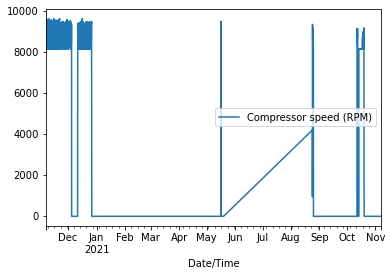

In [330]:
feature='Compressor speed (RPM)'

print(f"This dataset has {df1.shape[1]-1} features with {df1.shape[0]} Values for each feature.")
plt.figure(figsize=(10,8))
print(df1.plot(x='Date/Time', y=feature))

In [331]:
df1=df1[[feature]]
df1.head()

,Compressor speed (RPM)
1,8164.449219
2,8161.888184
3,8162.304688
4,8315.385742
5,8217.386719


In [332]:
values=df1.shape[0]
training=0.67 #Use 0.8 for default
what_to_train=values*training

df1_train=df1[:int(what_to_train)]
df1_test=df1[int(what_to_train):]

print(f"We have {len(df1_train)} Training Sets and {len(df1_test)} Testing Sets") 

We have 17608 Training Sets and 8673 Testing Sets


In [333]:
from sklearn.preprocessing import MinMaxScaler
sc=MinMaxScaler(feature_range=(0,1))
df1_scaled_train=sc.fit_transform(df1_train)
print(type(df1_scaled_train))
df1_scaled_train

<class 'numpy.ndarray'>


array([[0.84735862],
       [0.84709282],
       [0.84713604],
       ...,
       [0.22998159],
       [0.23004423],
       [0.23010687]])

In [334]:
df1_scaled_train.shape[0]

17608

In [335]:
hops=14
total_len=df1_scaled_train.shape[0]
X_train=[]
y_train=[]
for i in range(hops, total_len):
    X_train.append(df1_scaled_train[i-hops:i])
    y_train.append(df1_scaled_train[i])
X_train=np.array(X_train)
y_train=np.array(y_train)

In [336]:
print(len(X_train))
print(len(y_train))
print("---------")
print(f"The dimensions for X Train are {X_train.shape[0]}, {X_train.shape[1]}, {X_train.shape[2]}")
print(f"The dimensions for y Train are {y_train.shape[0]}, {y_train.shape[1]}")

m1_len=X_train.shape[0]
m2_len=X_train.shape[1]

17594
17594
---------
The dimensions for X Train are 17594, 14, 1
The dimensions for y Train are 17594, 1


In [337]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Flatten, Dropout

In [338]:
model=Sequential()
###########Adding Layer 1 LSTM##############
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(Dropout(0.2))
###########Adding Layer 2 LSTM############## 
model.add(LSTM(units=50))
model.add(Dropout(0.2))
###########Adding Dense Layer##############
model.add(Dense(1))
model.compile(optimizer='adam',loss='mean_squared_error')               

In [339]:
model.fit(X_train, y_train, epochs=75, batch_size=32)

Epoch 1/75
550/550 [==============================] - 9s 12ms/step - loss: 0.0046
Epoch 2/75
550/550 [==============================] - 7s 12ms/step - loss: 0.0023
Epoch 3/75
550/550 [==============================] - 7s 12ms/step - loss: 0.0019
Epoch 4/75
550/550 [==============================] - 7s 12ms/step - loss: 0.0016
Epoch 5/75
550/550 [==============================] - 7s 12ms/step - loss: 0.0014
Epoch 6/75
550/550 [==============================] - 7s 12ms/step - loss: 0.0014
Epoch 7/75
550/550 [==============================] - 7s 12ms/step - loss: 0.0013
Epoch 8/75
550/550 [==============================] - 7s 12ms/step - loss: 0.0013
Epoch 9/75
550/550 [==============================] - 7s 12ms/step - loss: 0.0013
Epoch 10/75
550/550 [==============================] - 7s 12ms/step - loss: 0.0013
Epoch 11/75
550/550 [==============================] - 7s 12ms/step - loss: 0.0012
Epoch 12/75
550/550 [==============================] - 7s 12ms/step - loss: 0.0012
Epoch 13/75
5

In [340]:
####### TESTING #######
df1_scaled_test=sc.fit_transform(df1_test)
print(type(df1_scaled_test))
df1_scaled_test

print(df1_scaled_train.shape[0])

total_len=df1_scaled_test.shape[0]
X_test=[]

for i in range(hops, total_len):
    X_test.append(df1_scaled_test[i-hops:i])
X_test=np.array(X_test)

print(len(X_test))
#print(len(y_test))
print("---------")
print(f"The dimensions for X Test are {X_test.shape[0]}, {X_test.shape[1]}, {X_test.shape[2]}")
#print(f"The dimensions for y Test are {y_test.shape[0]}, {y_test.shape[1]}")

m1b_len=X_test.shape[0]
m2b_len=X_test.shape[1]

<class 'numpy.ndarray'>
17608
8659
---------
The dimensions for X Test are 8659, 14, 1


In [341]:
y_test_pred=model.predict(X_test)

271/271 [==============================] - 1s 3ms/step


In [342]:
print(len(y_test_pred))
y_test_pred

y_test_pred_actual=sc.inverse_transform(y_test_pred)
y_test_pred_actual

8659


array([[2248.156   ],
       [2248.785   ],
       [2249.4138  ],
       ...,
       [ -52.138813],
       [ -52.138813],
       [ -52.138813]], dtype=float32)

In [343]:
test_pred_1=pd.DataFrame(y_test_pred_actual, columns=['Predicted'])
test_actual_1=df1_test[[feature]]
test_actual_1 = test_actual_1.reset_index(level=0, drop=True)
test_pred_1 = test_pred_1.reset_index(level=0, drop=True)

In [344]:
test_actual_1

,Compressor speed (RPM)
0,2217.723633
1,2218.327148
2,2218.930664
3,2219.534180
4,2220.137695
...,...
8668,0.000000
8669,0.000000
8670,0.000000
8671,0.000000


In [345]:
test_pred_1

,Predicted
0,2248.156006
1,2248.784912
2,2249.413818
3,2250.042725
4,2250.671387
...,...
8654,-52.138813
8655,-52.138813
8656,-52.138813
8657,-52.138813


In [346]:
# full_test_actual_1=pd.concat([test_pred_1, test_actual_1])
# full_test_actual_1

In [347]:
# plt.figure(figsize=(40,10))
# plt.plot(full_test_actual_1[feature],color='red', label='Actual Value')
# plt.plot(full_test_actual_1['Predicted'],color='blue', label='Predicted Value')
# plt.legend()
# plt.grid()
# plt.plot()

[]

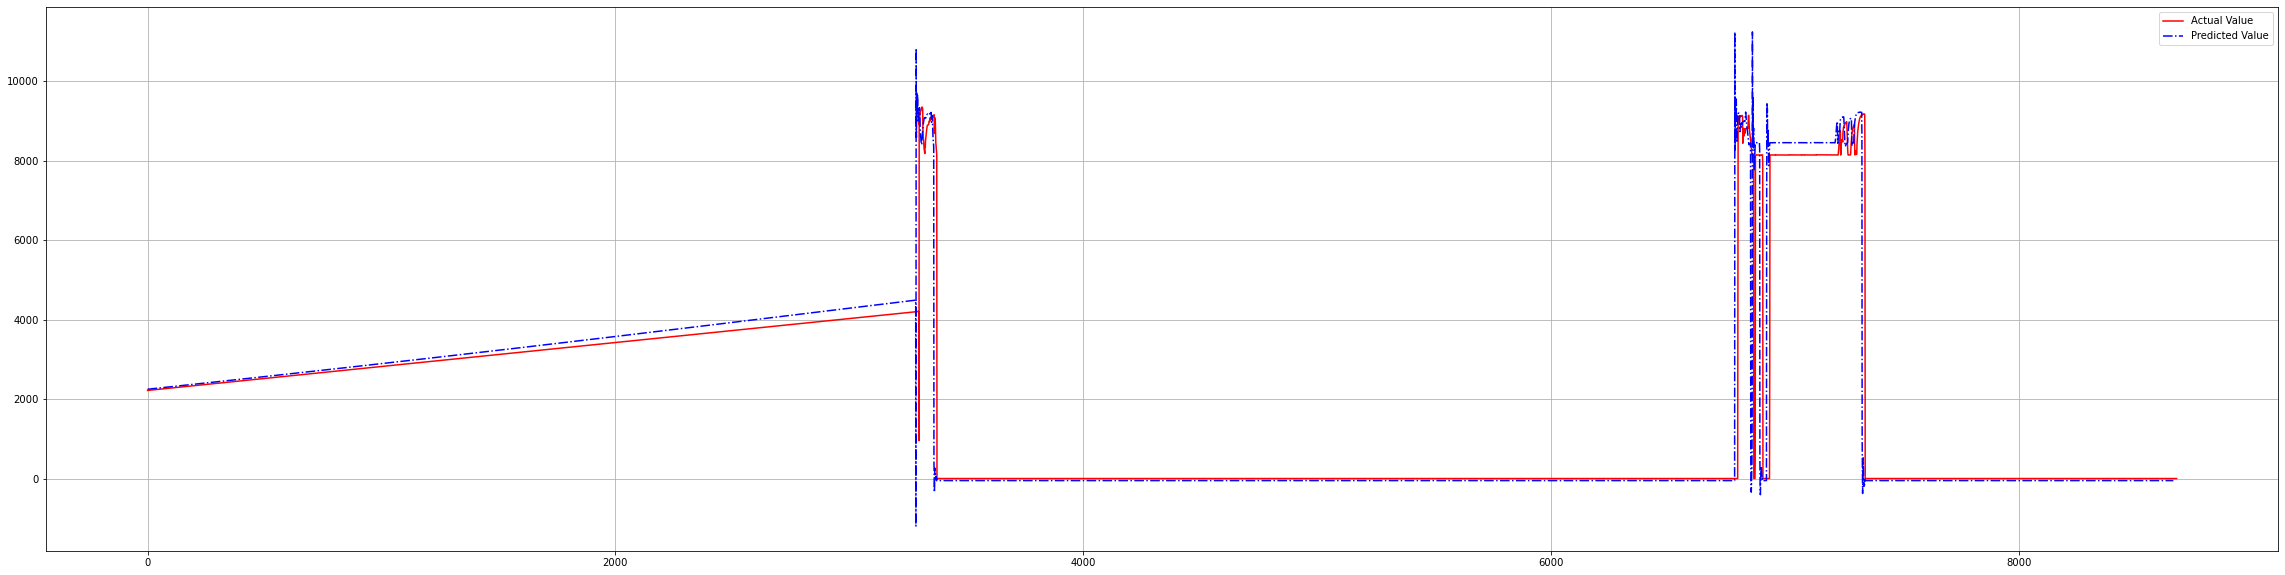

In [348]:
plt.figure(figsize=(40,10))
plt.plot(test_actual_1,color='red', label='Actual Value')
plt.plot(test_pred_1,color='blue', label='Predicted Value', linestyle='dashdot')
plt.legend()
plt.grid()
plt.plot()

In [349]:
# full_test_actual_1["Predicted"]

In [350]:
def MSE(actual, predicted):
    actual=np.array(actual)
    predicted=np.array(predicted)
    
    SE = (actual - predicted) ** 2
    MSE = np.mean(SE)
    
    return MSE

In [351]:
limit=len(test_pred_1)
mean_squared_error=MSE(test_actual_1[:limit], test_pred_1[:limit])
mean_squared_error

746454.7303210767

In [352]:
print(f"The Mean Squared Error after calculating the Univariative LSTM Model for the {feature} is {round(mean_squared_error, 2)}")

The Mean Squared Error after calculating the Univariative LSTM Model for the Compressor speed (RPM) is 746454.73
